In [58]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd

sys.path.append('..')
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
braking_df = pd.read_pickle('trial2_braking_ttc.p.gz')
steering_df = pd.read_pickle('trial2_steering_ttc.p.gz')

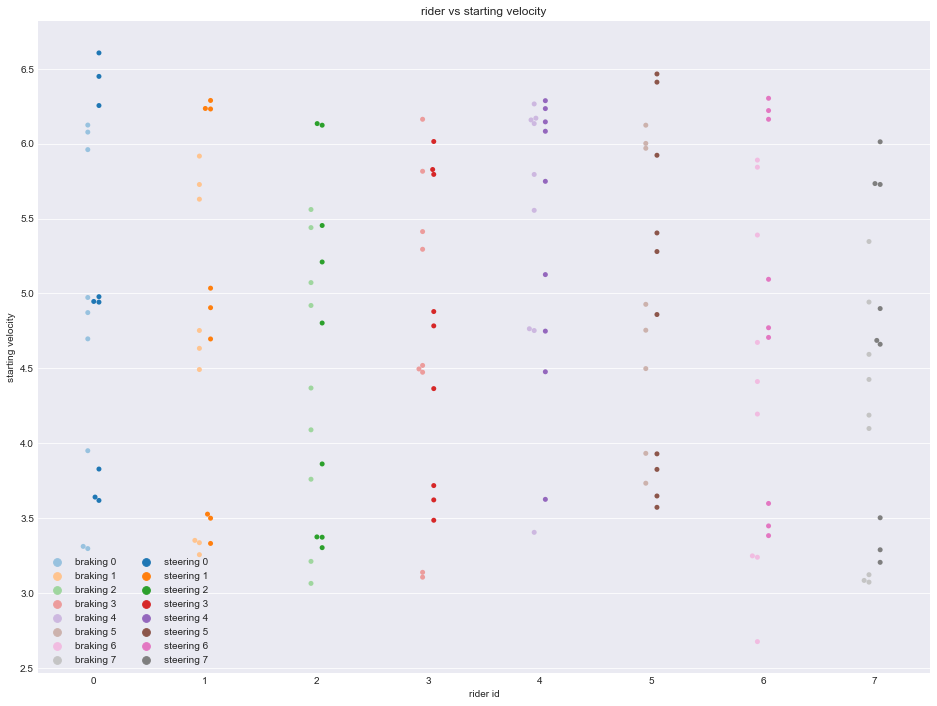

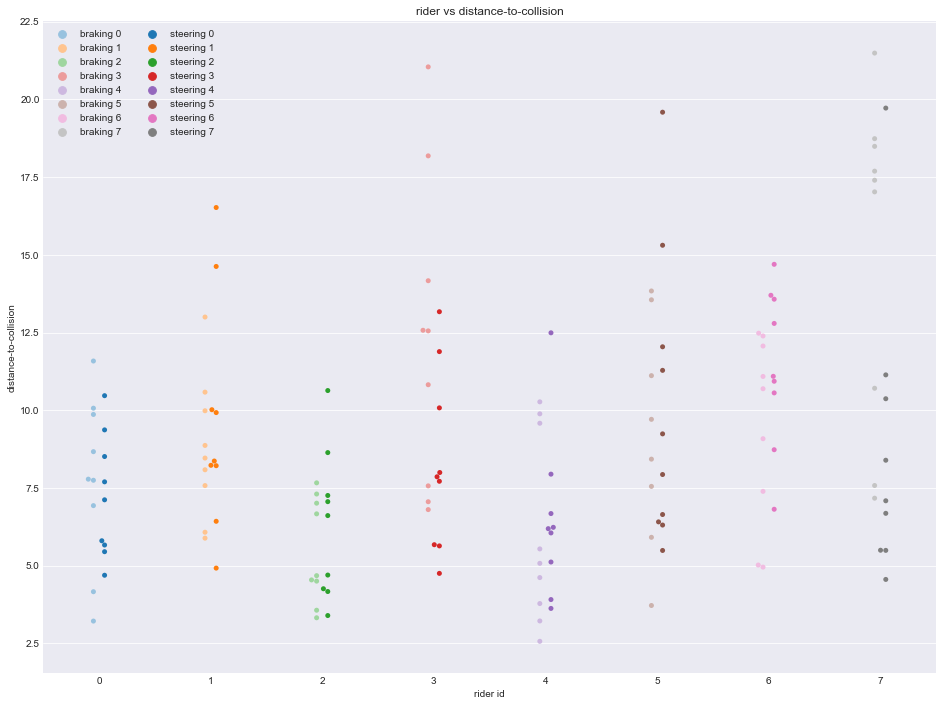

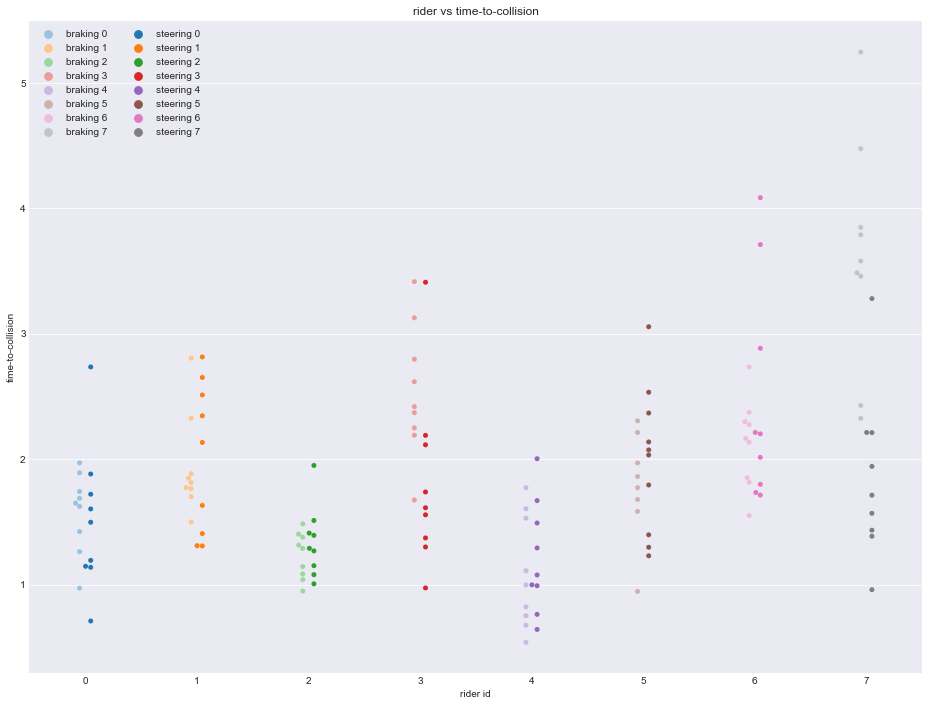

In [71]:
#%matplotlib notebook
#mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

def set_swarmplot_labels(ax, event_types):
    handles, labels = ax.get_legend_handles_labels()
    n = len(labels)
    assert n % 2 == 0 # check if even
    
    labels = ['{} {}'.format(event_type, rider_id)
              for event_type, rider_id in itertools.product(
                  event_types, labels[:n//2])]
    
    ax.legend(handles, labels, ncol=2)
    
def shift_swarmplot(ax, shift_value=0.05):
    collections = ax.collections
    n = len(collections)
    
    # collections are ordered as:
    # [c0, c1, c2, c3, x, x, x, x,
    #  c4, c5, c7, c6, x, x, x, x]
    collections = [c for i, c in enumerate(collections)
                   if (i//n) % n//4 == 0]
    
    for i, c in enumerate(collections):
        if i < n//4:
            sign = -1
        else:
            sign = 1
        
        offsets = c.get_offsets()
        shifts = np.matlib.repmat(
            np.array([[sign*shift_value, 0]]),
            offsets.shape[0], 1)
        
        c.set_offsets(offsets + shifts)
            
def plot_combined_swarm(y, df_filter=None):
    """
    y: dataframe column
    df_filter: dataframe filter function, description
    """
    paired_colors = []
    for c in sns.color_palette('tab10', 10):
        c_light = sns.light_palette(c)
        paired_colors.append(c_light[2])
        paired_colors.append(c)
    
    fig, ax = plt.subplots()
    
    def apply_filter(df):
        if df_filter is None:
            return df
        else:
            f = df_filter[0]
            return df[f(df)]
    
    sns.swarmplot(x='rider id', y=y, data=apply_filter(braking_df), ax=ax,
                  hue='rider id', palette=paired_colors[::2])
    sns.swarmplot(x='rider id', y=y, data=apply_filter(steering_df), ax=ax,
                  hue='rider id', palette=paired_colors[1::2])
    
    set_swarmplot_labels(ax, ['braking', 'steering'])
    shift_swarmplot(ax)

    title = 'rider vs {}'.format(y)
    if df_filter is not None:
        title = '{} ({})'.format(title, df_filter[1])
    ax.set_title(title) 
    return fig, ax

plt.close('all')

fig, ax = plot_combined_swarm('starting velocity')
plot_combined_swarm('distance-to-collision')
plot_combined_swarm('time-to-collision')

plt.show()

In [103]:
#%matplotlib notebook
#mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

def plot_combined_joint(x, y, df_filter=None, key=None, figsize=None):
    """
    x: dataframe column
    y: dataframe column
    df_filter: dataframe filter function, description
    """
    
    def apply_filter(df):
        if df_filter is None:
            return df
        else:
            f = df_filter[0]
            return df[f(df)]
        
    labels = ['braking', 'steering']
    if key is None:
        g = plotjoint(x, y, apply_filter(braking_df))
        g = plotjoint(x, y, apply_filter(steering_df), g=g)
        g.ax_joint.legend(labels)
    else:
        markers = ['o', 'P']
        
        paired_colors = []
        for c in sns.color_palette('tab10', 10):
            c_light = sns.light_palette(c)
            paired_colors.append(tuple(c_light[2][:3]))
            paired_colors.append(c)
            
        g = plotjoint(x, y, apply_filter(braking_df),
                      (key, paired_colors[::2]),
                      show_hull=False,
                      alpha=0.9,
                      marker=markers[0])
        
        g = plotjoint(x, y, apply_filter(steering_df),
                      (key, paired_colors[1::2]),
                      show_hull=False,
                      g=g,
                      alpha=0.9,
                      marker=markers[1])
        
        handles = []
        for (event_type, colors), k in itertools.product(
            zip(labels, [paired_colors[::2], paired_colors[1::2]]),
            steering_df[key].unique()):
            
            if event_type == 'braking':
                marker = markers[0]
            else:
                marker = markers[1]
                    
            h = mlines.Line2D(
                [], [], color=colors[k], marker=marker,
                markersize=6, linestyle=' ',
                label='{} {}'.format(event_type, k))
            handles.append(h)
        
        g.ax_joint.legend(handles=handles, ncol=2)
    
    if figsize is None:
        figsize = mpl.rcParams['figure.figsize']
    if figsize is not None:
        g.fig.set_size_inches(figsize)
        
    g.fig.subplots_adjust(top=0.9)
    title = '{} vs {}'.format(x, y)
    if df_filter is not None:
        title = '{} ({})'.format(title, df_filter[1])
    g.fig.suptitle(title)
    
    x = np.concatenate((braking_df[x].as_matrix(), steering_df[x].as_matrix()))
    y = np.concatenate((braking_df[y].as_matrix(), steering_df[y].as_matrix()))
    
    x_min = x.min()
    x_max = x.max()
    x_ptp = x_max - x_min
    
    y_min = y.min()
    y_max = y.max()
    y_ptp = y_max - y_min
    
    assert x_ptp > 0
    assert y_ptp > 0
    g.ax_joint.set_xlim((x_min - 0.1*x_ptp, x_max + 0.1*x_ptp))
    g.ax_joint.set_ylim((y_min - 0.1*y_ptp, y_max + 0.1*y_ptp))
    
    return g

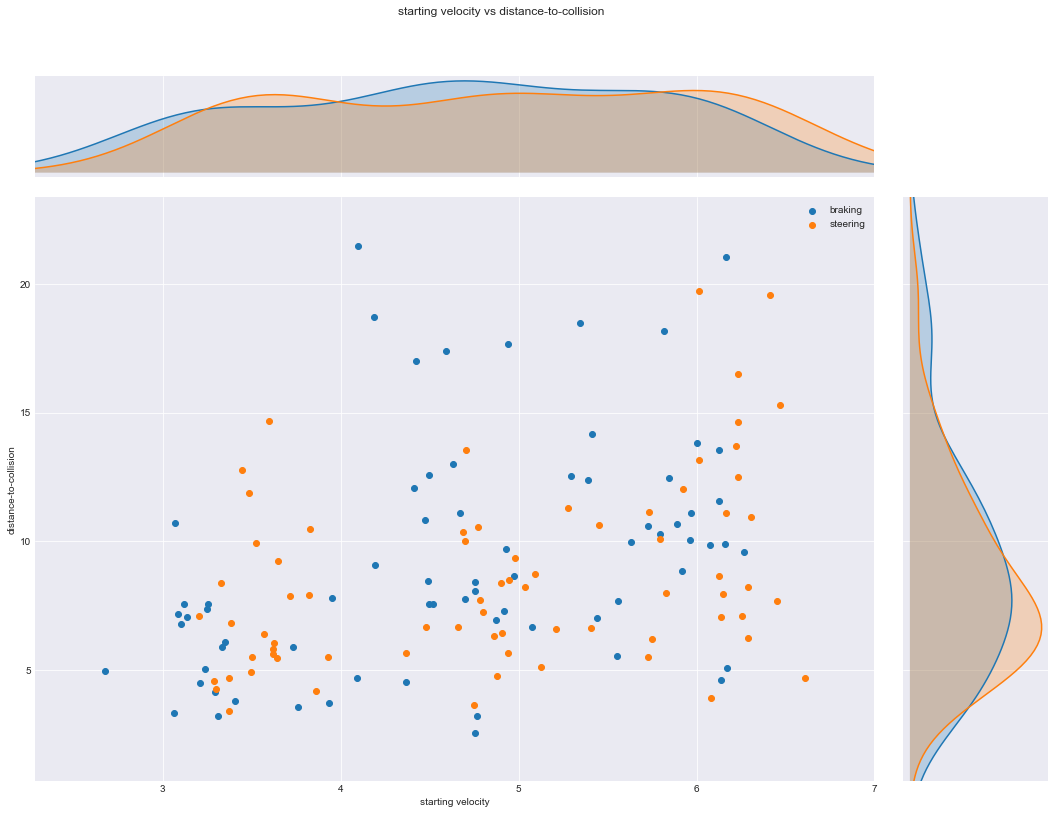

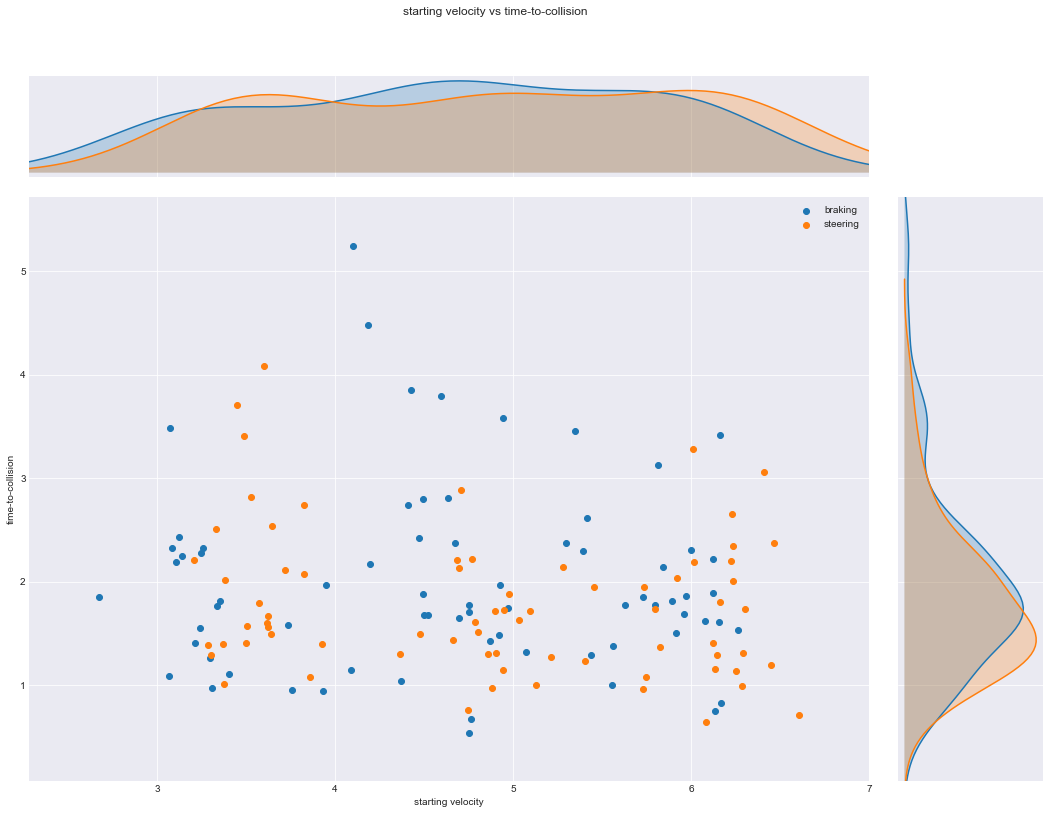

In [63]:
plt.close('all')
g = plot_combined_joint('starting velocity', 'distance-to-collision')
g = plot_combined_joint('starting velocity', 'time-to-collision')
plt.show()

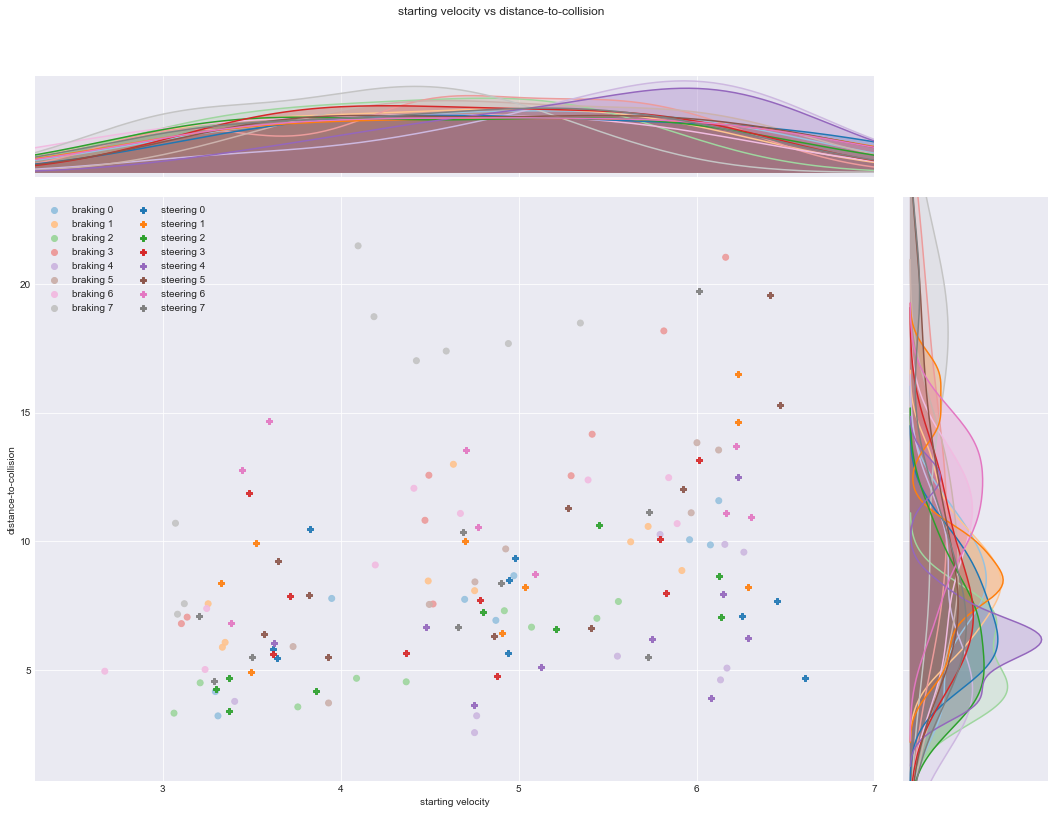

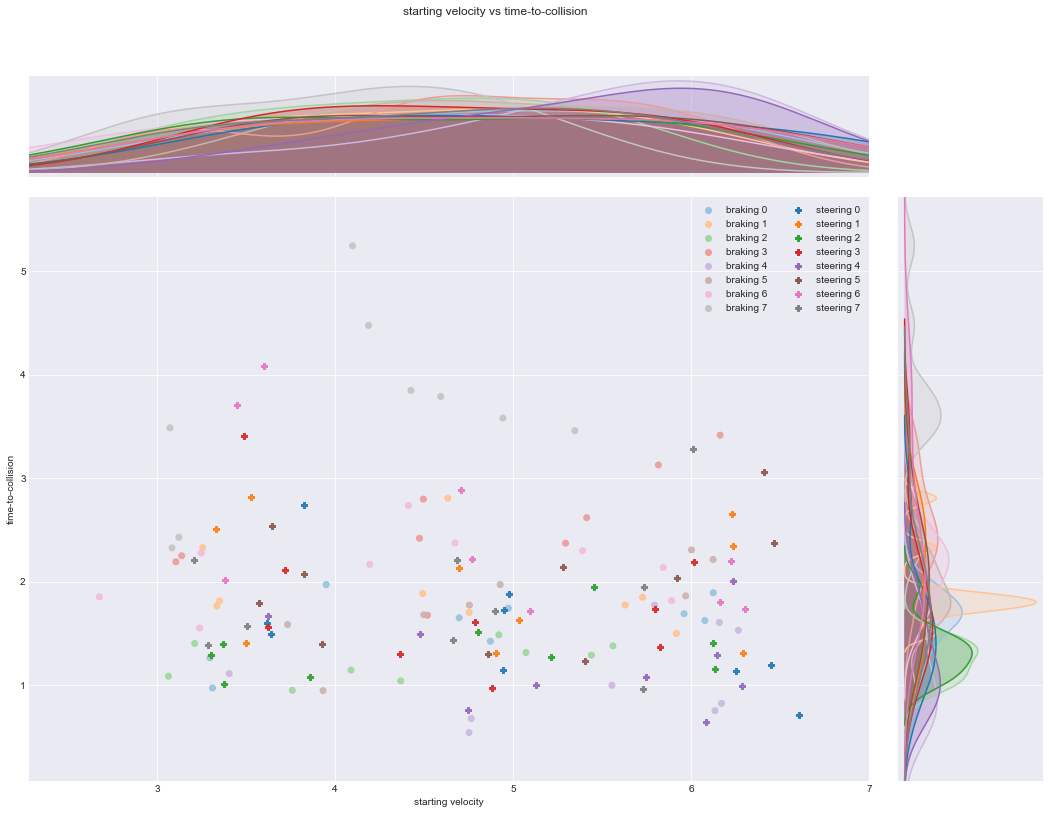

In [104]:
plt.close('all')
g = plot_combined_joint('starting velocity', 'distance-to-collision', key='rider id')
g = plot_combined_joint('starting velocity', 'time-to-collision', key='rider id')
plt.show()